# Outfit Data Generator

We want the MIL datasets to be identical from run to run. To do this, we'll produce CSVs with bag indices and labels.

This notebook builds an MIL dataset to decide whether a full outfit exists in the bag.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sklearn
from tensorflow.keras.datasets import fashion_mnist

# Set random seeds for consistency
random.seed(42)
np.random.seed(42)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


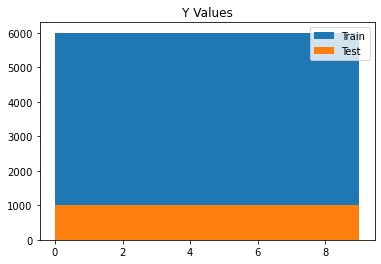

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

plt.hist(y_train)
plt.hist(y_test)
plt.legend(['Train', 'Test'])
plt.title('Y Values')
plt.show()
plt.close()

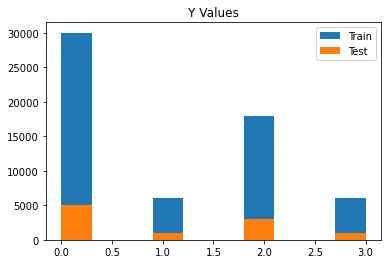

In [3]:
remap= {
  0: 0, # tshirt -> top
  2: 0, # pullover -> top
  3: 0, # dress -> top
  4: 0, # coat -> top
  6: 0, # shirt -> top
  
  1: 1, # trouser -> bottom
  
  5: 2, # sandals -> shoes
  7: 2, # sneaker -> shoes
  9: 2, # boots -> shoes
  
  8: 3, # bags -> bags
}

y_train = np.array([ remap[y] for y in y_train ])
y_test = np.array([ remap[y] for y in y_test ])

plt.hist(y_train)
plt.hist(y_test)
plt.legend(['Train', 'Test'])
plt.title('Y Values')
plt.show()
plt.close()

In [4]:
def pad(arr, max_size):
  p = np.empty(max_size - arr.shape[0])
  p.fill(-1)
  return np.concatenate([arr, p])

def bag_generator(x, y, get_label, min_size=3, max_size=7):
  x_shuf, y_shuf = sklearn.utils.shuffle(np.arange(x.shape[0]), y)

  x_bags = []
  y_bags = []
  
  i = 0
  
  while (x_shuf.shape[0] - i) > max_size:
    size = random.randrange(min_size, min(max_size, x_shuf.shape[0] - i - min_size))
    x_bags.append(pad(x_shuf[i:i + size], max_size))
    y_bags.append(get_label(y_shuf[i:i + size]))
    i += size

  x_bags.append(pad(x_shuf[i:], max_size))
  y_bags.append(get_label(y_shuf[i:]))

  return np.array(x_bags).astype(int), np.array(y_bags).astype(int)

def contains_outfit(labels):
  """Outfit needs top, bottom, and shoes."""
  return (0 in labels and 1 in labels and 2 in labels)

x_train_bags, y_train_bags = bag_generator(x_train, y_train, contains_outfit)
x_test_bags, y_test_bags = bag_generator(x_test, y_test, contains_outfit)


print(f'train: x={x_train_bags.shape}, y={y_train_bags.shape}, %={y_train_bags.sum() / y_train_bags.shape[0]}')
print(f'test : x={x_test_bags.shape}, y={y_test_bags.shape}, %={y_test_bags.sum() / y_test_bags.shape[0]}')

train: x=(13294, 7), y=(13294,), %=0.2487588385737927
test : x=(2233, 7), y=(2233,), %=0.24630541871921183


In [5]:
train = np.concatenate([y_train_bags[:, np.newaxis], x_train_bags], axis=1)
test = np.concatenate([y_test_bags[:, np.newaxis], x_test_bags], axis=1)

columns = ['y'] + [ f'x{i}' for i in range(train.shape[1] - 1)]

train_df = pd.DataFrame(train, columns=columns)
test_df = pd.DataFrame(test, columns=columns)

train_df.to_csv('data/outfit_train.csv')
test_df.to_csv('data/outfit_test.csv')